In [75]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.tokenize import word_tokenize
import nltk
from nltk import SnowballStemmer
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from sklearn import metrics
from nltk.tokenize import word_tokenize
from sklearn.metrics import f1_score

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from unidecode import unidecode
import json
import string
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

%matplotlib inline

##### Obtenção dos dados

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/prof-renato/data/main/humor_detection.csv')
df.dropna(inplace=True)

### Tratando textos

##### Importando um JSON com uma lista de palavras a serem substituidas

In [3]:
with open('contraction_map.json') as file:
    contration_map = json.load(file)

In [4]:
def apply_stemming(list_tokens, stemmer):
    return [stemmer.stem(token) for token in list_tokens]

In [5]:
def removeWords(listTokens, listWords):
    return [token for token in listTokens if token not in listWords]

In [6]:
def contration_words(text):
    for k, v in contration_map.items():
        text = text.replace(k, v)
    return text
    

In [7]:
def textProcess(text):
    stopWords = nltk.corpus.stopwords.words('english')

    text = text.replace(u'\ufffd', '8')
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.rstrip('\n')
    text = contration_words(text)

    listTokens = word_tokenize(text)
    listTokens= removeWords(listTokens, stopWords)

    text = " ".join(listTokens)
    text = unidecode(text)
    return text

In [8]:
random_forest_pipe = Pipeline([
    ('CountVectorizer', CountVectorizer(analyzer=textProcess)),
    ('TDFID', TfidfTransformer()),
    ('RandomForest', RandomForestClassifier())
])

multinomialNB_pipe = Pipeline([
    ('CountVectorizer', CountVectorizer(analyzer=textProcess)),
    ('TDFID', TfidfTransformer()),
    ('RandomForest', MultinomialNB())
])

logistic_regression_pipe = Pipeline([
    ('CountVectorizer', CountVectorizer(analyzer=textProcess)),
    ('TDFID', TfidfTransformer()),
    ('RandomForest', LogisticRegression())
])

In [9]:
df['humor'] = pd.to_numeric(df['humor'])

In [17]:
X = df['text']
y = df['humor']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


##### Utilizando o cross validantion

In [71]:
# logistic_regression_model = cross_validate(logistic_regression_pipe, X_train, y_train, scoring=['accuracy', 'f1', 'roc_auc'], return_train_score=True)
# random_forest_model = cross_validate(random_forest_pipe, X_train, y_train, scoring=['accuracy', 'f1', 'roc_auc'], return_train_score=True)
# multinomialnb_model = cross_validate(multinomialNB_pipe, X_train, y_train, scoring=['accuracy', 'f1', 'roc_auc'], return_train_score=True)

In [76]:
logistic_regression_model = logistic_regression_pipe.fit(X_train, y_train)
random_forest_model = random_forest_pipe.fit(X_train, y_train) 
multinomialnb_model = multinomialNB_pipe.fit(X_train, y_train)

d:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


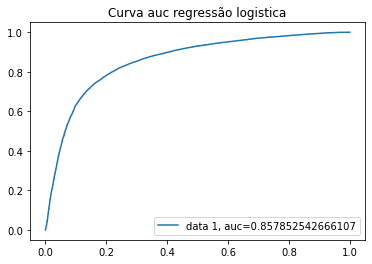

In [82]:
logistic_acc = logistic_regression_model.score(X_test, y_test)
logistic_pred = logistic_regression_model.predict(X_test)
logistic_pred_proba = logistic_regression_model.predict_proba(X_test)

fpr, tpr, _ = metrics.roc_curve(y_test,  logistic_pred_proba[::,1])
auc = metrics.roc_auc_score(y_test, logistic_pred_proba[::,1])
plt.title('Curva auc regressão logistica')
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

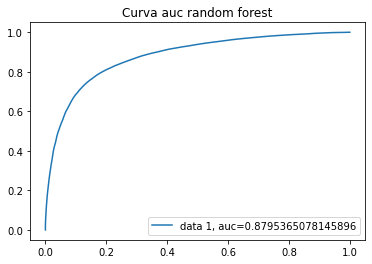

In [83]:
random_forest_acc = random_forest_model.score(X_test, y_test)
random_forest_pred = random_forest_model.predict(X_test)
random_forest_proba = random_forest_model.predict_proba(X_test)

fpr, tpr, _ = metrics.roc_curve(y_test,  random_forest_proba[::,1])
auc = metrics.roc_auc_score(y_test, random_forest_proba[::,1])
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.title('Curva auc random forest')

plt.legend(loc=4)
plt.show()


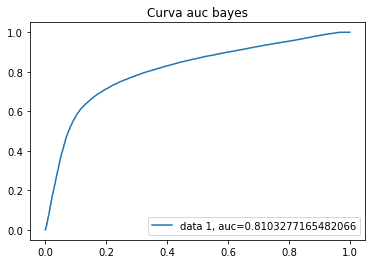

In [90]:
multinomialnb_acc = multinomialnb_model.score(X_test, y_test)
multinomialnb_pred = multinomialnb_model.predict(X_test)
multinomialnb_proba = multinomialnb_model.predict_proba(X_test)

fpr, tpr, _ = metrics.roc_curve(y_test,  multinomialnb_proba[::,1])
auc = metrics.roc_auc_score(y_test, multinomialnb_proba[::,1])
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.title('Curva auc bayes')
plt.legend(loc=4)
plt.show()

In [85]:
logistic_pred_f1 = f1_score(y_test, logistic_pred)

In [86]:
random_forest_f1 = f1_score(y_test, random_forest_pred)

In [87]:
multinomialnb_f1 = f1_score(y_test, multinomialnb_pred)

In [88]:
resultado = pd.DataFrame({
    'labels': ['accuracy', 'f1'],
    'logistic': [logistic_acc, logistic_pred_f1],
    'random_forest': [random_forest_acc, random_forest_f1],
    'multinomialNB': [multinomialnb_acc, multinomialnb_f1]
}).set_index('labels')
resultado.index.name=None
resultado = resultado.transpose()    
resultado.style.applymap(lambda x: 'background-color: lightgreen' if x >= 0.90 else '')

,accuracy,f1
logistic,0.790477,0.780058
random_forest,0.806659,0.796214
multinomialNB,0.757076,0.743770


In [91]:
from joblib import dump
# dump(logistic_regression_model, 'logistic_regression_model.joblib') 
# dump(random_forest_model, 'random_forest_model.joblib') 
# dump(multinomialnb_model, 'multinomialnb_model.joblib') 

['random_forest_model.joblib']